<a href="https://colab.research.google.com/github/as2c/MLP---Cosmology/blob/NewData/Optimization/SVM_data2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this code, our objective is to train some classic models such as SVM, KNN, RandomForest, etc on our test data, and try to evaluate their efficiency by plotting confusion matrixes, learning curves, validation curves, and measuring the prediction time. 

# Import phase I data

Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import timeit
import time
%alias_magic t timeit
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

Created `%t` as an alias for `%timeit`.
Created `%%t` as an alias for `%%timeit`.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Gadget 2 Data / with Neutrino

In [3]:
data = pd.read_csv(r'/content/drive/MyDrive/denc_Neutrino')
# data['in_halo'] = (data['haloID']>0).astype('int')
data['in_halo'] = (data['halo_mass']>1600).astype('int32')
data

,id,haloID,halo_mass,vx,vy,vz,dc for 4.9,dc for 6.8,dc for 8.7,dc for 10.6,dc for 12.4,dc for 14.3,dc for 16.2,dc for 18.1,dc for 20.0,in_halo
0,10156552,755,2280.0,171.21194,220.56293,-274.228700,-0.084922,-0.052028,-0.042415,-0.028087,-0.024984,-0.018675,-0.016231,-0.011940,-0.010111,1
1,11068486,85,1539.0,-129.84116,92.60424,212.125500,-0.127820,-0.081099,-0.051217,-0.028345,-0.013751,-0.013991,-0.012344,-0.011500,-0.012220,0
2,9530036,654,1944.0,-290.99210,-885.49430,468.255040,-0.078978,-0.052806,-0.030027,-0.011704,0.001295,0.003803,0.005131,0.005231,0.003787,1
3,11455022,752,1394.0,-60.35258,422.43716,79.394300,-0.109989,-0.079155,-0.054663,-0.037685,-0.026670,-0.017901,-0.009227,-0.000868,0.001568,0
4,8591034,356,1649.0,403.66608,345.88077,9.231552,-0.084405,-0.019068,-0.009396,-0.001539,0.002288,0.005629,0.011288,0.013111,0.013433,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2160800,451,2634.0,654.82430,210.78130,255.344150,-0.094225,-0.076043,-0.060624,-0.040368,-0.020840,-0.016261,-0.011803,-0.005002,0.000918,1
99996,3257728,43,1112.0,-154.27774,488.65564,-779.558400,-0.127045,-0.076529,-0.056246,-0.038201,-0.027520,-0.016374,-0.008045,0.002627,0.006124,0
99997,6101605,484,1198.0,-113.51735,68.44336,275.964000,-0.122135,-0.091794,-0.063465,-0.032060,-0.017973,-0.016684,-0.017740,-0.017154,-0.012600,0
99998,4576456,44,1058.0,-130.21120,292.63483,-754.563000,-0.097585,-0.076140,-0.061788,-0.054584,-0.043055,-0.032415,-0.021591,-0.007463,0.004673,0


In [4]:
data.describe()

,id,haloID,halo_mass,vx,vy,vz,dc for 4.9,dc for 6.8,dc for 8.7,dc for 10.6,dc for 12.4,dc for 14.3,dc for 16.2,dc for 18.1,dc for 20.0,in_halo
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,8.716004e+06,424.627710,2369.299450,35.207601,-13.728656,97.821939,-0.107338,-0.062074,-0.038666,-0.025951,-0.017900,-0.011968,-0.007224,-0.003341,-0.000224,0.557930
std,3.549230e+06,230.962533,1856.527585,364.820655,369.919751,373.578625,0.020301,0.020965,0.019921,0.018106,0.015956,0.013969,0.012346,0.011069,0.010084,0.496635
min,2.131444e+06,16.000000,241.000000,-1247.932500,-1462.806300,-1250.519700,-0.127820,-0.099572,-0.083351,-0.072824,-0.065316,-0.058751,-0.050519,-0.043771,-0.038371,0.000000
25%,5.953820e+06,238.000000,1194.000000,-226.284345,-254.656135,-145.829085,-0.124202,-0.077891,-0.052474,-0.038510,-0.028860,-0.021233,-0.015384,-0.010712,-0.006964,0.000000
50%,9.043250e+06,418.000000,1791.000000,32.857450,-4.815737,101.883413,-0.113607,-0.063404,-0.039434,-0.026100,-0.017784,-0.011980,-0.007369,-0.003743,-0.000713,1.000000
75%,1.176120e+07,619.000000,2945.000000,284.168098,238.543252,350.062135,-0.095776,-0.048722,-0.025370,-0.013587,-0.006677,-0.002087,0.001081,0.004249,0.006694,1.000000
max,1.464652e+07,870.000000,10101.000000,1314.092800,1256.822900,1355.984900,0.017155,0.032463,0.044346,0.040490,0.042179,0.036009,0.033482,0.034145,0.032602,1.000000


### Gadget 2 Data / without Neutrino

In [5]:
data_cdm = pd.read_csv(r'/content/drive/MyDrive/denc_CDM')
data_cdm['in_halo'] = (data_cdm['halo_mass']>1600).astype('int32')
data_cdm

,id,haloID,halo_mass,vx,vy,vz,dc for 4.9,dc for 6.8,dc for 8.7,dc for 10.6,dc for 12.4,dc for 14.3,dc for 16.2,dc for 18.1,dc for 20.0,in_halo
0,8981131,414,1504.0,252.710050,-464.239500,509.94550,2.817576,2.780794,2.746420,2.446413,2.000415,1.533108,1.083378,0.691070,0.457584,0
1,9901676,1026,1013.0,-167.701370,499.161740,156.32635,2.690323,2.102417,1.805493,1.485764,1.267945,1.083753,0.849938,0.617267,0.431845,0
2,8288987,1079,727.0,46.129280,19.954561,164.61870,1.010590,0.821528,0.559744,0.220796,0.003400,-0.094805,-0.074599,0.003315,0.076079,0
3,4842631,675,1268.0,-234.629320,349.021400,-690.46674,1.889611,1.180236,0.495534,0.064434,-0.232441,-0.389582,-0.407908,-0.334146,-0.231578,0
4,12884124,437,6128.0,146.780670,-180.209270,-558.39777,2.676619,1.734870,0.906903,0.464721,0.187801,0.057663,0.029529,0.049055,0.101472,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,12466311,1085,5542.0,25.253933,-580.586850,113.06337,1.482403,1.068278,0.857863,0.583947,0.327563,0.212553,0.139374,0.103515,0.090791,1
99996,11857185,491,691.0,-423.371550,138.109020,-300.80450,-0.209077,-0.534490,-0.724460,-0.749430,-0.743152,-0.663805,-0.511928,-0.347015,-0.253660,0
99997,9340191,947,868.0,225.385210,-9.085627,318.22006,1.086942,0.492283,0.114506,-0.050883,-0.161068,-0.168421,-0.159639,-0.175261,-0.202931,0
99998,13317963,1034,1175.0,-55.431606,16.332230,-898.90326,0.339088,-0.085185,-0.248881,-0.328230,-0.343797,-0.306353,-0.275684,-0.282089,-0.284524,0


In [6]:
data_cdm.describe()

,id,haloID,halo_mass,vx,vy,vz,dc for 4.9,dc for 6.8,dc for 8.7,dc for 10.6,dc for 12.4,dc for 14.3,dc for 16.2,dc for 18.1,dc for 20.0,in_halo
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,8.533738e+06,633.075900,3004.391080,32.287533,-13.697343,89.574071,1.423915,1.032233,0.712873,0.480862,0.322917,0.216223,0.144046,0.096634,0.066060,0.589200
std,3.598448e+06,358.496156,2802.876192,359.880883,364.383569,374.571567,1.023549,0.920945,0.807251,0.689640,0.585773,0.502089,0.436403,0.384151,0.341271,0.491981
min,2.131195e+06,3.000000,271.000000,-1234.874100,-1571.376600,-1311.024700,-0.994127,-0.912349,-0.878283,-0.891915,-0.933043,-0.935449,-0.868262,-0.815454,-0.787467,0.000000
25%,5.640789e+06,368.000000,1181.000000,-223.982345,-249.685410,-148.388917,0.660156,0.354545,0.122621,-0.026842,-0.107359,-0.161173,-0.183527,-0.186967,-0.181568,0.000000
50%,8.790886e+06,676.000000,2020.000000,28.124724,-4.978945,97.944227,1.269011,0.890765,0.589027,0.370513,0.223129,0.134561,0.074502,0.037988,0.011761,1.000000
75%,1.143724e+07,970.000000,3662.000000,277.156240,231.618633,341.305498,2.057976,1.549992,1.162333,0.872826,0.674880,0.526476,0.422276,0.353801,0.294427,1.000000
max,1.464654e+07,1251.000000,31252.000000,1362.093800,1185.835400,1349.211900,5.624963,4.721646,3.972765,3.400808,2.783131,2.163220,1.888203,1.618024,1.364662,1.000000


## Define Datasets

In [7]:
## Neutrino
X = data.iloc[:,3:15].astype('float32').values
Y = data.in_halo.astype('int32').values

In [8]:
## CDM
X2 = data_cdm.iloc[:,3:15].astype('float32').values
Y2 = data_cdm.in_halo.astype('int32').values

In [9]:
## Scale / Neutrino
X = (X - np.mean(X))/np.std(X)

In [10]:
## Scale / CDM
X2 = (X2 - np.mean(X2))/np.std(X2)

In [11]:
## Split into test and train / Neutrino

tst_size = 0.2
ns, nf = np.shape(X) 
X_train, X_test, Y_train, Y_test = train_test_split(*shuffle(X, Y, n_samples = ns, random_state=0) , random_state=0, test_size =tst_size )
print('X_train :',len(X_train),'   X_test :',len(X_test))

X_train : 80000    X_test : 20000


In [12]:
## Split into test and train / CDM

tst_size = 0.2
ns, nf = np.shape(X) 
X2_train, X2_test, Y2_train, Y2_test = train_test_split(*shuffle(X, Y, n_samples = ns, random_state=0) , random_state=0, test_size =tst_size )
print('X2_train :',len(X2_train),'   X2_test :',len(X2_test))

X2_train : 80000    X2_test : 20000


In [13]:
# Frequency of 1-class / Neutrino
print("{} % of the stored data has class 1 ".format(100*Y.sum()/len(Y)))

55.793 % of the stored data has class 1 


In [14]:
# Frequency of 1-class / CDM
print("{} % of the stored data has class 1 ".format(100*Y2.sum()/len(Y2)))

58.92 % of the stored data has class 1 


# SVM 

Initialize and train svm model

In [15]:
# from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import time

svc = svm.SVC()
tst_size = 0.2
ns, nf = np.shape(X) 
# split data to train and test 
X_train, X_test, Y_train, Y_test = train_test_split(*shuffle(X, Y, n_samples = ns, random_state=0) , random_state=0, test_size =tst_size )
# cross validation
# scores = cross_val_score(svc, X_train, Y_train, cv=5 ,scoring= 'f1')
cv = 3
scoring = 'f1'
param_grid = {'C': [0.1, 100],  
                'gamma': [1, 0.001], 
                'kernel': ['rbf', 'sigmoid']}
# evaluate hyper-parameters 
clf = GridSearchCV(svc, param_grid, scoring = scoring, cv = cv ,verbose = 1, n_jobs=-1, return_train_score=1)
# train model
start_train = time.time()
trained_model = clf.fit(X_train, Y_train)
runtime_train = start_train - time.time()
# predict data
start_pred = time.time()
Y_pred = trained_model.predict(X_test)
runtime_pred = start_pred - time.time()
# scores = cross_val_score(clf.best_estimator_, X_train, Y_train, cv=5 ,scoring= 'accuracy')
# print(scores)
print(clf.best_score_)

## runtime order = 3 hr

Fitting 3 folds for each of 8 candidates, totalling 24 fits
0.7163544464823675


In [16]:
import pickle

# save the model to disk
filename = 'drive/MyDrive/svm_model.sav'
pickle.dump(trained_model, open(filename, 'wb'))
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

### Classification Report
Print some information about the trained model such as training time, ... 

In [17]:
print("Best parameters set found on development set:")
print(trained_model.best_params_)
print()
# print(sorted(trained_model.cv_results_.keys()))
print(trained_model.best_score_)
# print(trained_model.cv_results_.mean_fit)

print('-----------------')
# print(Y_pred)
print('\nclassification report: \n')
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

EM1 = scoring
mean_test_scores = trained_model.cv_results_.get('mean_test_score')
CVS1 = mean_test_scores[trained_model.best_index_]
CPS1 = trained_model.score(X_test, Y_test)
T1 = runtime_train
PT1 = runtime_pred
print( "Training Time was: " + str(T1))
print("Prediction Time was: " + str(PT1))

Best parameters set found on development set:
{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}

0.7163544464823675
-----------------

classification report: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8852
           1       0.56      1.00      0.72     11148

    accuracy                           0.56     20000
   macro avg       0.28      0.50      0.36     20000
weighted avg       0.31      0.56      0.40     20000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Time was: -11914.655703306198
Prediction Time was: -99.0941174030304


### Confusion Matrix

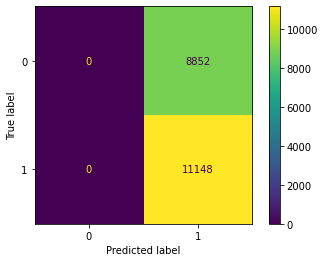

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

### Learning Curve


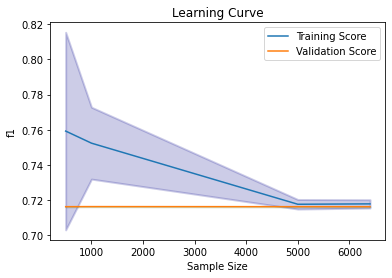

Training scores:

            cv1       cv2       cv3
100        NaN  0.770186  0.770186
500   0.838560  0.719590  0.719590
1000  0.781231  0.737975  0.737975
5000  0.721555  0.715808  0.715808
6400  0.721279  0.716277  0.716277

 ----------------------------------------------------------------------

Validation scores:

            cv1       cv2       cv3
100        NaN  0.710096  0.710897
500   0.716359  0.716359  0.716345
1000  0.716359  0.716379  0.716455
5000  0.716359  0.716359  0.716345
6400  0.716359  0.716359  0.716345


In [20]:
ns = [100,500,1000,5000,6400]
train_sizes, train_scores, valid_scores = learning_curve(trained_model, X_train, Y_train, train_sizes=ns, cv=cv, scoring= scoring, n_jobs = -1)

train_scores_mean =  train_scores.mean(axis = 1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean =  valid_scores.mean(axis = 1)
validation_scores_std  = valid_scores.std(axis = 1)

xlabel = 'Sample Size'
ylabel = scoring
plt_title = 'Learning Curve'

fig = plt.figure()
ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
ax.plot(train_sizes, train_scores_mean, label = 'Training Score')
ax.plot(train_sizes, validation_scores_mean, label = 'Validation Score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkblue", lw=2)
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.2,
                 color="darkgreen", lw=2)

plt.legend()
# plt.yscale('log')
plt.show()

print('Training scores:\n\n', pd.DataFrame( train_scores, columns=[f'cv{i+1}' for i in range(cv)], index=ns) )
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', pd.DataFrame(valid_scores, columns=[f'cv{i+1}' for i in range(cv)], index=ns) )

### Validation Curve


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 57.2min finished


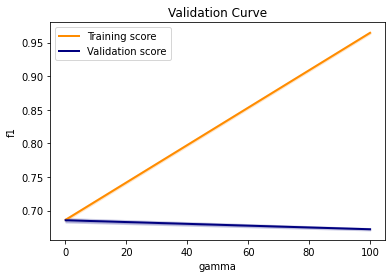

In [21]:
c_list = param_grid.get('C')
train_scores, valid_scores = validation_curve(SVC(), X_train, Y_train, 
                                              param_name="gamma",
                                              param_range=c_list , 
                                              cv=cv, 
                                              scoring = scoring,
                                              verbose=1, 
                                              n_jobs=-1
                                             )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

xlabel = 'gamma'
ylabel = scoring
plt_title = 'Validation Curve'

fig = plt.figure()
ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
plt.plot(c_list, train_scores_mean, label="Training score",
             color="darkorange", lw=2)
plt.fill_between(c_list, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=2)
plt.plot(c_list, valid_scores_mean, label="Validation score",
             color="navy", lw=2)
plt.fill_between(c_list, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=2)
plt.legend(loc="best")
plt.show()

# print('Training scores:\n\n', pd.DataFrame( train_scores, columns=[f'cv{i+1}' for i in range(cv)], index=ns) )
# print('\n', '-' * 70) # separator to make the output easy to read
# print('\nValidation scores:\n\n', pd.DataFrame(valid_scores, columns=[f'cv{i+1}' for i in range(cv)], index=ns) )

# SVM / CDM

In [ ]:
# from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import time

svc = svm.SVC()
ns, nf = np.shape(X2) 

# cross validation
# scores = cross_val_score(svc, X2_train, Y2_train, cv=5 ,scoring= 'f1')
cv = 3
scoring = 'f1'
param_grid = {'C': [0.1, 100],  
                'gamma': [1, 0.001], 
                'kernel': ['rbf', 'sigmoid']}
# evaluate hyper-parameters 
clf = GridSearchCV(svc, param_grid, scoring = scoring, cv = cv ,verbose = 1, n_jobs=-1, return_train_score=1)
# train model
start_train = time.time()
trained_model = clf.fit(X2_train, Y2_train)
runtime_train = start_train - time.time()
# predict data
start_pred = time.time()
Y2_pred = trained_model.predict(X2_test)
runtime_pred = start_pred - time.time()
# scores = cross_val_score(clf.best_estimator_, X2_train, Y2_train, cv=5 ,scoring= 'accuracy')
# print(scores)
print(clf.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [ ]:
import pickle

# save the model to disk
filename = 'drive/MyDrive/svm_model_cdm.sav'
pickle.dump(trained_model, open(filename, 'wb'))
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X2_test, Y2_test)
# print(result)

### Classification Report
Print some information about the trained model such as training time, ... 

In [ ]:
# print("Best parameters set found on development set:")
# print(trained_model.best_params_)
# print()
# # print(sorted(trained_model.cv_results_.keys()))
# print(trained_model.best_score_)
# print(trained_model.cv_results_.mean_fit)

# train model
start_train = time.time()
trained_model = clf.fit(X2_train, Y2_train)
runtime_train = start_train - time.time()
# predict data
start_pred = time.time()
Y2_pred = trained_model.predict(X2_test)
runtime_pred = start_pred - time.time()
print('-----------------')
# print(Y_pred)
print('\nclassification report: \n')
from sklearn.metrics import classification_report
print(classification_report(Y2_test, Y2_pred))

EM2 = scoring
mean_test_scores = trained_model.cv_results_.get('mean_test_score')
CVS2 = mean_test_scores[trained_model.best_index_]
CPS2 = trained_model.score(X2_test, Y2_test)
T2 = runtime_train
PT2 = runtime_pred
print( "Training Time was: " + str(T2))
print("Prediction Time was: " + str(PT2))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


### Confusion Matrix

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(Y2_test, Y2_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

### Learning Curve


In [ ]:
ns = [100,500,1000,5000,6400]
train_sizes, train_scores, valid_scores = learning_curve(trained_model, X_train, Y_train, train_sizes=ns, cv=cv, scoring= scoring, n_jobs = -1)

train_scores_mean =  train_scores.mean(axis = 1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean =  valid_scores.mean(axis = 1)
validation_scores_std  = valid_scores.std(axis = 1)

xlabel = 'Sample Size'
ylabel = scoring
plt_title = 'Learning Curve'

fig = plt.figure()
ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
ax.plot(train_sizes, train_scores_mean, label = 'Training Score')
ax.plot(train_sizes, validation_scores_mean, label = 'Validation Score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkblue", lw=2)
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.2,
                 color="darkgreen", lw=2)

plt.legend()
# plt.yscale('log')
plt.show()

print('Training scores:\n\n', pd.DataFrame( train_scores, columns=[f'cv{i+1}' for i in range(cv)], index=ns) )
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', pd.DataFrame(valid_scores, columns=[f'cv{i+1}' for i in range(cv)], index=ns) )

### Validation Curve


In [ ]:
c_list = param_grid.get('C')
train_scores, valid_scores = validation_curve(SVC(), X_train, Y_train, 
                                              param_name="gamma",
                                              param_range=c_list , 
                                              cv=cv, 
                                              scoring = scoring,
                                              verbose=1, 
                                              n_jobs=-1
                                             )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

xlabel = 'gamma'
ylabel = scoring
plt_title = 'Validation Curve'

fig = plt.figure()
ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
plt.plot(c_list, train_scores_mean, label="Training score",
             color="darkorange", lw=2)
plt.fill_between(c_list, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=2)
plt.plot(c_list, valid_scores_mean, label="Validation score",
             color="navy", lw=2)
plt.fill_between(c_list, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=2)
plt.legend(loc="best")
plt.show()

# print('Training scores:\n\n', pd.DataFrame( train_scores, columns=[f'cv{i+1}' for i in range(cv)], index=ns) )
# print('\n', '-' * 70) # separator to make the output easy to read
# print('\nValidation scores:\n\n', pd.DataFrame(valid_scores, columns=[f'cv{i+1}' for i in range(cv)], index=ns) )

# Comparing Models

A table is created to compare the five recently-traind models above. It includes evaluation metric(s), training time and prediction time of each models. Also, we sorted models based on their performance from different aspects. 

In [ ]:
table = pd.DataFrame({'Name':['Neutrino','CDM'],
                        'Evaluation Metric(s)': [EM1, EM2],
                        'Corresponding Validation Score': [CVS1, CVS2],
                        'Corresponding Prediction Score':  [CPS1, CPS2],
                        'Training Time': [T1, T2],
                        'Prediction Time': [PT1, PT2]
})

print('Sort models based on their validation scores: \n' + str(table.sort_values(by=['Corresponding Validation Score'], ascending= False).loc[:, ['Name', 'Corresponding Validation Score']]))
print('\nSort models based on their prediction scores: \n' + str(table.sort_values(by=['Corresponding Prediction Score'], ascending= False).loc[:, ['Name', 'Corresponding Prediction Score']]))
print('\nSort models based on their training time: \n' + str(table.sort_values(by=['Training Time'], ascending= True).loc[:, ['Name', 'Training Time']]))
print('\nSort models based on their prediction time: \n' + str(table.sort_values(by=['Prediction Time'], ascending= True).loc[:, ['Name', 'Prediction Time']]))
